<a href="https://colab.research.google.com/github/tsmanral/Author-Prediction-Using-Deep-Learning-Models/blob/master/POS_Model_for_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D
from keras.layers import Flatten, GlobalAveragePooling1D
from keras.layers import Embedding, TimeDistributed
import keras.utils
from keras.callbacks import ModelCheckpoint  


In [0]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.9
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data_pos')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1OIo2AFE5433kfj9QGpGJVYERoWcmXVzB' in parents"}).GetList()

data = []
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  with open(fname, 'r', encoding = "ISO-8859-1") as file:
    data.append([f['title'].split('-')[0], file.read()])

title: George Gissing - 2.txt, id: 1lCMmjhdF4MlD8mWVVhMgdUDv7Hki3_-d
downloading to /content/data_pos/George Gissing - 2.txt
title: Humphrey Ward - 13.txt, id: 1yP2cZU3-djw5epRNhUyRf3Cprc-adBtq
downloading to /content/data_pos/Humphrey Ward - 13.txt
title: George Gissing - 15.txt, id: 16Qap744WSUYEpbPIYRfIWnxAkB5rnXiL
downloading to /content/data_pos/George Gissing - 15.txt
title: Arthur Conan Doyle - 11.txt, id: 1HB_DcPLPafswhFbgjRYImH8GfBvghplJ
downloading to /content/data_pos/Arthur Conan Doyle - 11.txt
title: Humphrey Ward - 10.txt, id: 1Tiqv8_lApsZPbgANKnGH_NmXotwmNx4G
downloading to /content/data_pos/Humphrey Ward - 10.txt
title: Arthur Conan Doyle - 10.txt, id: 1nRXK4FBhXvehImie22HvK4qG5FISiHFu
downloading to /content/data_pos/Arthur Conan Doyle - 10.txt
title: Arthur Conan Doyle - 7.txt, id: 1nz4_r-CvQZwKg91cnAvsHQE7UvA4eWoj
downloading to /content/data_pos/Arthur Conan Doyle - 7.txt
title: Henry Rider Haggard - 7.txt, id: 1vfyVPEJUqVHhyQd-4rJ4qLCfxoAY5kDO
downloading to /conte

title: Gilbert Parker - 13.txt, id: 1O-O3f6NFXYFZYy9f5HkIVKIEqNH9sgy_
downloading to /content/data_pos/Gilbert Parker - 13.txt
title: Arthur Conan Doyle - 16.txt, id: 1WXzRRGG2pt9QC3a1oan3Wg-Hfe3QJBLi
downloading to /content/data_pos/Arthur Conan Doyle - 16.txt
title: Henry Rider Haggard - 12.txt, id: 1oDjEYDQjP7KdxO2VpzU08m5kJXdPOTK4
downloading to /content/data_pos/Henry Rider Haggard - 12.txt
title: Henry Rider Haggard - 25.txt, id: 1BrlRls7K1mCOdefL5Ih0Cr3jFpfxGqbv
downloading to /content/data_pos/Henry Rider Haggard - 25.txt
title: Arthur Conan Doyle - 12.txt, id: 1PSFBrdrggGe1b_1Z2O5WdnlHkdFSFOo_
downloading to /content/data_pos/Arthur Conan Doyle - 12.txt
title: Arthur Conan Doyle - 4.txt, id: 1p-XRhYDQCdccoYflkHuAdXkZVOwjpfdm
downloading to /content/data_pos/Arthur Conan Doyle - 4.txt
title: Humphrey Ward - 8.txt, id: 1E3UCDg2V70_N1nxpFSsrAiyBVziTMRdl
downloading to /content/data_pos/Humphrey Ward - 8.txt
title: Gilbert Parker - 7.txt, id: 1I2AgUyOdTnZ76rTHjsQRUmANa5P_5pqH
down

title: Gilbert Parker - 5.txt, id: 1atkDIkWgZN0xOYrLc0CAcmtS5x1kJqD0
downloading to /content/data_pos/Gilbert Parker - 5.txt
title: Henry Rider Haggard - 9.txt, id: 1IDmhDWbLnsoPrRkQwdrejXAm3WL4Z7m8
downloading to /content/data_pos/Henry Rider Haggard - 9.txt
title: Humphrey Ward - 14.txt, id: 1CzoKzHf8dCmvKo_x5Bd7cDxpUaINqowR
downloading to /content/data_pos/Humphrey Ward - 14.txt
title: Gilbert Parker - 12.txt, id: 1n_S6h-ax02aDj8sGXNLGqrHRtHhCR8eh
downloading to /content/data_pos/Gilbert Parker - 12.txt
title: Arthur Conan Doyle - 5.txt, id: 1UVH3T5AUm6Xyd7W4q-H07H1gOGkD17-g
downloading to /content/data_pos/Arthur Conan Doyle - 5.txt
title: Gilbert Parker - 6.txt, id: 1smgTQyEwOyvyB1bxp2YIF03urzWAkr3A
downloading to /content/data_pos/Gilbert Parker - 6.txt
title: Humphrey Ward - 15.txt, id: 1mgS1p_sVn70GjneAqQryC43fUphPZ1gC
downloading to /content/data_pos/Humphrey Ward - 15.txt
title: Henry Rider Haggard - 19.txt, id: 17kGjYBSqYp4RwYY8HIL3-pphflfxxKbw
downloading to /content/data_p

In [0]:
X = []
for _,c in data:
    X.append(c.lower())
    
Y = []
for i,_ in data:
    Y.append(i.lower())

X1 = []
Y_data1 = []

for text in X:
  c = text.strip().split()
  X1.append(c)

print(len(X))
X_data1 = []
count = 0
for i in X1:
  m=0
  n=1000
  times = len(i)//1000
  for j in range(times):
    X_data1.append(i[m:n])
    m = m + 1000
    n = n + 1000
    Y_data1.append(Y[count]) 
  X_data1.append(i[m:len(i)+1])
  Y_data1.append(Y[count])
  count = count + 1 



98


In [0]:
temp_list = []
for i in range(len(X_data1)):
  temp_list.append([X_data1[i], Y_data1[i]])
print(len(temp_list))
print(temp_list[0][1])

import random

random.shuffle(temp_list)
print(len(temp_list))
print(temp_list[0][1])

X_data = []
Y_data = []
for i in range(len(temp_list)):
  X_data.append(temp_list[i][0])
  Y_data.append(temp_list[i][1])
print(len(X_data), len(Y_data))
print(X_data[0], Y_data[0])

11163
george gissing 
11163
henry rider haggard 
11163 11163
['vbn', 'nnp', 'in', 'nns', 'vbp', 'vbn', 'in', 'jj', 'nn', 'cc', 'dt', 'vbz', 'rb', 'prp$', 'nn', 'jj', 'vbp', 'vbn', 'nn', 'in', 'prp', 'vbp', 'vbn', 'prp', 'vbd', 'in', 'prp$', 'fw', 'fw', 'vbd', 'prp', 'vbp', 'rb', 'in', 'dt', 'nn', 'in', 'dt', 'nnp', 'nn', 'cc', 'dt', 'nnp', 'nnp', 'vbz', 'prp$', 'nn', 'dt', 'nn', 'rb', 'md', 'vb', 'dt', 'nn', 'vbd', 'dt', 'vb', 'prp$', 'nn', 'nn', 'in', 'dt', 'nn', 'prp$', 'nn', 'rb', 'in', 'wdt', 'vbz', 'vbn', 'in', 'nn', 'nn', 'in', 'dt', 'jj', 'nn', 'in', 'nn', 'prp', 'vbp', 'nn', 'in', 'prp', 'wp', 'vbp', 'jj', 'nn', 'cc', 'nn', 'in', 'nn', 'prp', 'vbp', 'prp', 'in', 'prp', 'vbd', 'fw', 'fw', 'prp', 'vbp', 'prp', 'jj', 'cc', 'jj', 'in', 'dt', 'nn', 'in', 'cd', 'fw', 'fw', 'prp$', 'nn', 'vb', 'prp$', 'nn', 'to', 'prp', 'cc', 'nn', 'prp', 'vbp', 'nn', 'prp', 'vbd', 'prp', 'vbp', 'prp', 'vbp', 'in', 'dt', 'nn', 'in', 'dt', 'nns', 'vbd', 'wrb', 'nnp', 'vbd', 'in', 'prp$', 'nn', 'cc', 'i

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Converting Output values to One Hot Vector
print("Converting to One hot vector(training set)...")
Y_data = np.array(Y_data)

label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(Y_data)
print(train_integer_encoded)


Converting to One hot vector(training set)...
[3 1 0 ... 4 1 4]


In [0]:
train_onehot_encoded = keras.utils.to_categorical(train_integer_encoded)
print(train_onehot_encoded[2824,:])

[1. 0. 0. 0. 0.]


In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
print(vocab_size)

35


In [0]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_data)
print(encoded_docs[0])

[14, 9, 2, 11, 16, 14, 2, 4, 1, 7, 3, 19, 8, 12, 1, 4, 16, 14, 1, 2, 6, 16, 14, 6, 5, 2, 12, 10, 10, 5, 6, 16, 8, 2, 3, 1, 2, 3, 9, 1, 7, 3, 9, 9, 19, 12, 1, 3, 1, 8, 18, 13, 3, 1, 5, 3, 13, 12, 1, 1, 2, 3, 1, 12, 1, 8, 2, 20, 19, 14, 2, 1, 1, 2, 3, 4, 1, 2, 1, 6, 16, 1, 2, 6, 22, 16, 4, 1, 7, 1, 2, 1, 6, 16, 6, 2, 6, 5, 10, 10, 6, 16, 6, 4, 7, 4, 2, 3, 1, 2, 21, 10, 10, 12, 1, 13, 12, 1, 15, 6, 7, 1, 6, 16, 1, 6, 5, 6, 16, 6, 16, 2, 3, 1, 2, 3, 11, 5, 23, 9, 5, 2, 12, 1, 7, 2, 3, 1, 2, 12, 1, 3, 1, 2, 9, 5, 8, 15, 3, 1, 6, 16, 9, 22, 1, 9, 3, 1, 6, 5, 6, 2, 9, 7, 9, 3, 1, 7, 3, 1, 5, 4, 2, 12, 1, 5, 24, 1, 7, 7, 2, 6, 6, 18, 8, 13, 14, 1, 6, 5, 6, 2, 3, 1, 7, 1, 21, 7, 21, 4, 1, 1, 22, 16, 6, 9, 9, 5, 2, 3, 1, 10, 10, 6, 1, 7, 8, 1, 6, 5, 2, 3, 1, 1, 6, 19, 2, 3, 1, 2, 3, 4, 9, 1, 22, 19, 8, 8, 17, 2, 3, 1, 15, 13, 7, 6, 8, 5, 2, 3, 1, 1, 2, 3, 11, 12, 11, 8, 18, 13, 1, 7, 1, 18, 8, 13, 6, 13, 6, 5, 2, 1, 7, 2, 1, 6, 5, 1, 21, 7, 1, 6, 5, 10, 10, 23, 16, 6, 13, 6, 16, 22, 19, 6, 15, 1

In [0]:
# pad documents to a max length of 10000 words
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[ 8 17  2 ...  2  3  1]
 [11  5  4 ... 14 15 13]
 [ 4  1 15 ... 15 13  2]
 ...
 [ 3  4  4 ... 11  2 12]
 [ 7 12  1 ... 30  1  2]
 [ 1  7  1 ...  5  7  5]]


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1ogZLyJ5GTI8a0o8HPac8zTtm96SzCv-k' in parents"}).GetList()
print(file_list[0]['title'], file_list[0]['id'] )
fname = os.path.join(local_download_path, file_list[0]['title'])
f_ = drive.CreateFile({'id': file_list[0]['id']})
f_.GetContentFile(fname)


# load the whole embedding into memory
embeddings_index = dict()
f = open(fname)
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

glove.6B.100d.txt 17BmrNJa4oJDNg3KZ6u2Ww0ETQYklOJJ7
Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(35, 100)


In [0]:
print(padded_docs.shape)
doc_train = np.array(padded_docs[0:8000,:])
print(doc_train.shape)
doc_test = np.array(padded_docs[8000:,:])
print(doc_test.shape)

onehot_train = np.array(train_onehot_encoded[0:8000,:])
print(onehot_train.shape)
onehot_test = np.array(train_onehot_encoded[8000:,:])
print(onehot_test.shape)

(11163, 200)
(8000, 200)
(3163, 200)
(8000, 5)
(3163, 5)


In [0]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=200, trainable=False)
model.add(e)
#model.add(Conv1D(32, 3, border_mode='valid'))
#model.add(Conv1D(64, 3, border_mode='valid'))
model.add(LSTM(512, activation='tanh', return_sequences=False))

#model.add(GlobalAveragePooling1D())

#model.add(Dropout(0.3))
#model.add(Flatten())
#model.add(Dense(5000, activation='relu'))
#model.add(Dropout(0.1))


#model.add(Dense(1000, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dropout(0.6))

model.add(Dense(500, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.6))




model.add(Dense(5, activation='softmax'))
#model.add(TimeDistributed(Dense(100, activation='softmax')))

In [0]:
# compile the model
num_of_epochs = 100
batchsize = 64
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          3500      
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               256500    
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 2505      
Total params: 1,517,929
Trainable params: 1,514,429
Non-trainable params: 3,500
______________________________________________________________

In [0]:
checkpointer = ModelCheckpoint(filepath='/content/weights.best.RNN_pos.hdf5', 
                              verbose=1, save_best_only=True)

In [0]:
# fit the model
history = model.fit(doc_train, onehot_train, epochs=num_of_epochs, verbose=1, batch_size=batchsize, validation_split=0.2, callbacks=[checkpointer])

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 54s 8ms/step - loss: 1.5851 - categorical_accuracy: 0.2878 - val_loss: 1.5524 - val_categorical_accuracy: 0.3287

Epoch 00001: val_loss improved from inf to 1.55240, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 2/100
6400/6400 [==============================] - 53s 8ms/step - loss: 1.5556 - categorical_accuracy: 0.3219 - val_loss: 1.5354 - val_categorical_accuracy: 0.3225

Epoch 00002: val_loss improved from 1.55240 to 1.53540, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 3/100
3520/6400 [===============>..............] - ETA: 22s - loss: 1.5257 - categorical_accuracy: 0.3301

6400/6400 [==============================] - 53s 8ms/step - loss: 1.5149 - categorical_accuracy: 0.3430 - val_loss: 1.4801 - val_categorical_accuracy: 0.3550

Epoch 00003: val_loss improved from 1.53540 to 1.48007, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 4/100
6400/6400 [==============================] - 53s 8ms/step - loss: 1.4736 - categorical_accuracy: 0.3750 - val_loss: 1.4101 - val_categorical_accuracy: 0.3812

Epoch 00004: val_loss improved from 1.48007 to 1.41006, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 5/100
5504/6400 [========================>.....] - ETA: 7s - loss: 1.4463 - categorical_accuracy: 0.4053

6400/6400 [==============================] - 54s 8ms/step - loss: 1.4380 - categorical_accuracy: 0.4072 - val_loss: 1.3707 - val_categorical_accuracy: 0.4163

Epoch 00005: val_loss improved from 1.41006 to 1.37071, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 6/100
6400/6400 [==============================] - 53s 8ms/step - loss: 1.3791 - categorical_accuracy: 0.4403 - val_loss: 1.2937 - val_categorical_accuracy: 0.4481

Epoch 00006: val_loss improved from 1.37071 to 1.29374, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 7/100
5824/6400 [==========================>...] - ETA: 4s - loss: 1.3079 - categorical_accuracy: 0.4820

6400/6400 [==============================] - 53s 8ms/step - loss: 1.3210 - categorical_accuracy: 0.4769 - val_loss: 1.4290 - val_categorical_accuracy: 0.4156

Epoch 00007: val_loss did not improve
Epoch 8/100
6400/6400 [==============================] - 53s 8ms/step - loss: 1.2412 - categorical_accuracy: 0.5314 - val_loss: 1.1607 - val_categorical_accuracy: 0.5575

Epoch 00008: val_loss improved from 1.29374 to 1.16073, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 9/100
6400/6400 [==============================] - 53s 8ms/step - loss: 1.1676 - categorical_accuracy: 0.5673 - val_loss: 1.2774 - val_categorical_accuracy: 0.5369

Epoch 00009: val_loss did not improve
Epoch 10/100
 640/6400 [==>...........................] - ETA: 46s - loss: 1.1258 - categorical_accuracy: 0.5828

6400/6400 [==============================] - 53s 8ms/step - loss: 1.1143 - categorical_accuracy: 0.6002 - val_loss: 1.2313 - val_categorical_accuracy: 0.5413

Epoch 00010: val_loss did not improve
Epoch 11/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.9320 - categorical_accuracy: 0.6637 - val_loss: 0.8070 - val_categorical_accuracy: 0.7200

Epoch 00011: val_loss improved from 1.16073 to 0.80702, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 12/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.7394 - categorical_accuracy: 0.7434 - val_loss: 0.5898 - val_categorical_accuracy: 0.7987



Epoch 00012: val_loss improved from 0.80702 to 0.58976, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 13/100
6400/6400 [==============================] - 52s 8ms/step - loss: 0.6494 - categorical_accuracy: 0.7837 - val_loss: 0.6515 - val_categorical_accuracy: 0.7944

Epoch 00013: val_loss did not improve
Epoch 14/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.4903 - categorical_accuracy: 0.8447 - val_loss: 0.3051 - val_categorical_accuracy: 0.9087

Epoch 00014: val_loss improved from 0.58976 to 0.30506, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 15/100
3008/6400 [=============>................] - ETA: 26s - loss: 0.3849 - categorical_accuracy: 0.8863

6400/6400 [==============================] - 53s 8ms/step - loss: 0.3564 - categorical_accuracy: 0.8937 - val_loss: 0.2785 - val_categorical_accuracy: 0.9219

Epoch 00015: val_loss improved from 0.30506 to 0.27847, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 16/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.2664 - categorical_accuracy: 0.9177 - val_loss: 0.3334 - val_categorical_accuracy: 0.9031

Epoch 00016: val_loss did not improve
Epoch 17/100
6080/6400 [===========================>..] - ETA: 2s - loss: 0.2216 - categorical_accuracy: 0.9410

6400/6400 [==============================] - 52s 8ms/step - loss: 0.2173 - categorical_accuracy: 0.9422 - val_loss: 0.2940 - val_categorical_accuracy: 0.9387

Epoch 00017: val_loss did not improve
Epoch 18/100
6400/6400 [==============================] - 52s 8ms/step - loss: 0.2044 - categorical_accuracy: 0.9448 - val_loss: 0.1589 - val_categorical_accuracy: 0.9625

Epoch 00018: val_loss improved from 0.27847 to 0.15891, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 19/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.1556 - categorical_accuracy: 0.9617 - val_loss: 0.1261 - val_categorical_accuracy: 0.9706

Epoch 00019: val_loss improved from 0.15891 to 0.12608, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 20/100
 576/6400 [=>............................] - ETA: 44s - loss: 0.0834 - categorical_accuracy: 0.9826

6400/6400 [==============================] - 53s 8ms/step - loss: 0.1195 - categorical_accuracy: 0.9689 - val_loss: 0.1186 - val_categorical_accuracy: 0.9725

Epoch 00020: val_loss improved from 0.12608 to 0.11857, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 21/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.1035 - categorical_accuracy: 0.9752 - val_loss: 0.0916 - val_categorical_accuracy: 0.9881

Epoch 00021: val_loss improved from 0.11857 to 0.09159, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 22/100
5056/6400 [======================>.......] - ETA: 10s - loss: 0.1586 - categorical_accuracy: 0.9745

6400/6400 [==============================] - 53s 8ms/step - loss: 0.1524 - categorical_accuracy: 0.9731 - val_loss: 0.0501 - val_categorical_accuracy: 0.9831

Epoch 00022: val_loss improved from 0.09159 to 0.05013, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 23/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.1005 - categorical_accuracy: 0.9789 - val_loss: 0.0489 - val_categorical_accuracy: 0.9894

Epoch 00023: val_loss improved from 0.05013 to 0.04889, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 24/100
5696/6400 [=========================>....] - ETA: 5s - loss: 0.0734 - categorical_accuracy: 0.9828

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0812 - categorical_accuracy: 0.9817 - val_loss: 0.1112 - val_categorical_accuracy: 0.9756

Epoch 00024: val_loss did not improve
Epoch 25/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0710 - categorical_accuracy: 0.9828 - val_loss: 0.0857 - val_categorical_accuracy: 0.9825

Epoch 00025: val_loss did not improve
Epoch 26/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0692 - categorical_accuracy: 0.9842 - val_loss: 0.0514 - val_categorical_accuracy: 0.9844

Epoch 00026: val_loss did not improve
Epoch 27/100
1280/6400 [=====>........................] - ETA: 39s - loss: 0.0827 - categorical_accuracy: 0.9773

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0571 - categorical_accuracy: 0.9873 - val_loss: 0.0540 - val_categorical_accuracy: 0.9894

Epoch 00027: val_loss did not improve
Epoch 28/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0763 - categorical_accuracy: 0.9836 - val_loss: 0.0380 - val_categorical_accuracy: 0.9906

Epoch 00028: val_loss improved from 0.04889 to 0.03801, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 29/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0460 - categorical_accuracy: 0.9894 - val_loss: 0.7609 - val_categorical_accuracy: 0.9231

Epoch 00029: val_loss did not improve
Epoch 30/100


6400/6400 [==============================] - 53s 8ms/step - loss: 0.0775 - categorical_accuracy: 0.9859 - val_loss: 0.0861 - val_categorical_accuracy: 0.9838

Epoch 00030: val_loss did not improve
Epoch 31/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0386 - categorical_accuracy: 0.9917 - val_loss: 0.0598 - val_categorical_accuracy: 0.9919

Epoch 00031: val_loss did not improve
Epoch 32/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0449 - categorical_accuracy: 0.9909 - val_loss: 0.0670 - val_categorical_accuracy: 0.9906

Epoch 00032: val_loss did not improve
Epoch 33/100
 512/6400 [=>............................] - ETA: 45s - loss: 0.0351 - categorical_accuracy: 0.9922

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0888 - categorical_accuracy: 0.9856 - val_loss: 0.1560 - val_categorical_accuracy: 0.9800

Epoch 00033: val_loss did not improve
Epoch 34/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0355 - categorical_accuracy: 0.9931 - val_loss: 0.1906 - val_categorical_accuracy: 0.9700

Epoch 00034: val_loss did not improve
Epoch 35/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0588 - categorical_accuracy: 0.9908 - val_loss: 0.0683 - val_categorical_accuracy: 0.9888

Epoch 00035: val_loss did not improve
Epoch 36/100
 576/6400 [=>............................] - ETA: 45s - loss: 0.0167 - categorical_accuracy: 0.9948

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0525 - categorical_accuracy: 0.9911 - val_loss: 0.0378 - val_categorical_accuracy: 0.9938

Epoch 00036: val_loss improved from 0.03801 to 0.03783, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 37/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0475 - categorical_accuracy: 0.9920 - val_loss: 0.0369 - val_categorical_accuracy: 0.9925

Epoch 00037: val_loss improved from 0.03783 to 0.03690, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 38/100
5056/6400 [======================>.......] - ETA: 10s - loss: 0.0362 - categorical_accuracy: 0.9921

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0470 - categorical_accuracy: 0.9902 - val_loss: 0.0841 - val_categorical_accuracy: 0.9888

Epoch 00038: val_loss did not improve
Epoch 39/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0600 - categorical_accuracy: 0.9919 - val_loss: 0.0641 - val_categorical_accuracy: 0.9919

Epoch 00039: val_loss did not improve
Epoch 40/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0417 - categorical_accuracy: 0.9931 - val_loss: 0.0654 - val_categorical_accuracy: 0.9925

Epoch 00040: val_loss did not improve
Epoch 41/100
1152/6400 [====>.........................] - ETA: 41s - loss: 0.0237 - categorical_accuracy: 0.9948

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0288 - categorical_accuracy: 0.9955 - val_loss: 0.1010 - val_categorical_accuracy: 0.9881

Epoch 00041: val_loss did not improve
Epoch 42/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0395 - categorical_accuracy: 0.9934 - val_loss: 0.0495 - val_categorical_accuracy: 0.9919

Epoch 00042: val_loss did not improve
Epoch 43/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0556 - categorical_accuracy: 0.9923 - val_loss: 0.0988 - val_categorical_accuracy: 0.9862

Epoch 00043: val_loss did not improve
Epoch 44/100
 640/6400 [==>...........................] - ETA: 44s - loss: 0.0021 - categorical_accuracy: 0.9984

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0377 - categorical_accuracy: 0.9945 - val_loss: 0.0571 - val_categorical_accuracy: 0.9931

Epoch 00044: val_loss did not improve
Epoch 45/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0398 - categorical_accuracy: 0.9930 - val_loss: 0.0509 - val_categorical_accuracy: 0.9944

Epoch 00045: val_loss did not improve
Epoch 46/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0841 - categorical_accuracy: 0.9897 - val_loss: 0.0587 - val_categorical_accuracy: 0.9938

Epoch 00046: val_loss did not improve
Epoch 47/100
 576/6400 [=>............................] - ETA: 44s - loss: 0.0410 - categorical_accuracy: 0.9948

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0354 - categorical_accuracy: 0.9950 - val_loss: 0.0896 - val_categorical_accuracy: 0.9831

Epoch 00047: val_loss did not improve
Epoch 48/100
6400/6400 [==============================] - 54s 8ms/step - loss: 0.0510 - categorical_accuracy: 0.9931 - val_loss: 0.0536 - val_categorical_accuracy: 0.9931

Epoch 00048: val_loss did not improve
Epoch 49/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0339 - categorical_accuracy: 0.9947 - val_loss: 0.0638 - val_categorical_accuracy: 0.9931

Epoch 00049: val_loss did not improve
Epoch 50/100
 576/6400 [=>............................] - ETA: 45s - loss: 0.0019 - categorical_accuracy: 1.0000

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0303 - categorical_accuracy: 0.9961 - val_loss: 0.0476 - val_categorical_accuracy: 0.9931

Epoch 00050: val_loss did not improve
Epoch 51/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0264 - categorical_accuracy: 0.9963 - val_loss: 0.0682 - val_categorical_accuracy: 0.9931

Epoch 00051: val_loss did not improve
Epoch 52/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0213 - categorical_accuracy: 0.9967 - val_loss: 0.0539 - val_categorical_accuracy: 0.9950

Epoch 00052: val_loss did not improve
Epoch 53/100
 512/6400 [=>............................] - ETA: 46s - loss: 0.0069 - categorical_accuracy: 0.9980

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0537 - categorical_accuracy: 0.9944 - val_loss: 0.1264 - val_categorical_accuracy: 0.9875

Epoch 00053: val_loss did not improve
Epoch 54/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0654 - categorical_accuracy: 0.9920 - val_loss: 0.0651 - val_categorical_accuracy: 0.9919

Epoch 00054: val_loss did not improve
Epoch 55/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0233 - categorical_accuracy: 0.9977 - val_loss: 0.0831 - val_categorical_accuracy: 0.9894

Epoch 00055: val_loss did not improve
Epoch 56/100
 576/6400 [=>............................] - ETA: 44s - loss: 0.0200 - categorical_accuracy: 0.9931

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0496 - categorical_accuracy: 0.9936 - val_loss: 0.0746 - val_categorical_accuracy: 0.9931

Epoch 00056: val_loss did not improve
Epoch 57/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0242 - categorical_accuracy: 0.9970 - val_loss: 0.0531 - val_categorical_accuracy: 0.9944

Epoch 00057: val_loss did not improve
Epoch 58/100
6400/6400 [==============================] - 52s 8ms/step - loss: 0.0454 - categorical_accuracy: 0.9934 - val_loss: 0.0941 - val_categorical_accuracy: 0.9881

Epoch 00058: val_loss did not improve
Epoch 59/100
 576/6400 [=>............................] - ETA: 45s - loss: 0.0348 - categorical_accuracy: 0.9965

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0281 - categorical_accuracy: 0.9958 - val_loss: 0.0514 - val_categorical_accuracy: 0.9962

Epoch 00059: val_loss did not improve
Epoch 60/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0476 - categorical_accuracy: 0.9948 - val_loss: 0.0552 - val_categorical_accuracy: 0.9950

Epoch 00060: val_loss did not improve
Epoch 61/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0221 - categorical_accuracy: 0.9970 - val_loss: 0.0501 - val_categorical_accuracy: 0.9969

Epoch 00061: val_loss did not improve
Epoch 62/100
 576/6400 [=>............................] - ETA: 44s - loss: 0.0531 - categorical_accuracy: 0.9948

6400/6400 [==============================] - 52s 8ms/step - loss: 0.0395 - categorical_accuracy: 0.9947 - val_loss: 0.1231 - val_categorical_accuracy: 0.9888

Epoch 00062: val_loss did not improve
Epoch 63/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0302 - categorical_accuracy: 0.9966 - val_loss: 0.0528 - val_categorical_accuracy: 0.9950

Epoch 00063: val_loss did not improve
Epoch 64/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0691 - categorical_accuracy: 0.9920 - val_loss: 0.0442 - val_categorical_accuracy: 0.9956

Epoch 00064: val_loss did not improve
Epoch 65/100
 576/6400 [=>............................] - ETA: 45s - loss: 0.1325 - categorical_accuracy: 0.9844

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0432 - categorical_accuracy: 0.9942 - val_loss: 0.0669 - val_categorical_accuracy: 0.9931

Epoch 00065: val_loss did not improve
Epoch 66/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0291 - categorical_accuracy: 0.9966 - val_loss: 0.0688 - val_categorical_accuracy: 0.9931

Epoch 00066: val_loss did not improve
Epoch 67/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0582 - categorical_accuracy: 0.9925 - val_loss: 0.1105 - val_categorical_accuracy: 0.9894

Epoch 00067: val_loss did not improve
Epoch 68/100
 576/6400 [=>............................] - ETA: 46s - loss: 0.0494 - categorical_accuracy: 0.9913

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0368 - categorical_accuracy: 0.9947 - val_loss: 0.0569 - val_categorical_accuracy: 0.9925

Epoch 00068: val_loss did not improve
Epoch 69/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0548 - categorical_accuracy: 0.9933 - val_loss: 0.0644 - val_categorical_accuracy: 0.9919

Epoch 00069: val_loss did not improve
Epoch 70/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0296 - categorical_accuracy: 0.9955 - val_loss: 0.0955 - val_categorical_accuracy: 0.9881

Epoch 00070: val_loss did not improve
Epoch 71/100
 576/6400 [=>............................] - ETA: 45s - loss: 0.0564 - categorical_accuracy: 0.9965

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0448 - categorical_accuracy: 0.9942 - val_loss: 0.0666 - val_categorical_accuracy: 0.9900

Epoch 00071: val_loss did not improve
Epoch 72/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0257 - categorical_accuracy: 0.9958 - val_loss: 0.0364 - val_categorical_accuracy: 0.9938

Epoch 00072: val_loss improved from 0.03690 to 0.03643, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 73/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0295 - categorical_accuracy: 0.9956 - val_loss: 0.0402 - val_categorical_accuracy: 0.9969



Epoch 00073: val_loss did not improve
Epoch 74/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0267 - categorical_accuracy: 0.9964 - val_loss: 0.0680 - val_categorical_accuracy: 0.9931

Epoch 00074: val_loss did not improve
Epoch 75/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0397 - categorical_accuracy: 0.9958 - val_loss: 0.0749 - val_categorical_accuracy: 0.9931

Epoch 00075: val_loss did not improve
Epoch 76/100
5312/6400 [=======================>......] - ETA: 8s - loss: 0.0231 - categorical_accuracy: 0.9968

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0200 - categorical_accuracy: 0.9972 - val_loss: 0.0887 - val_categorical_accuracy: 0.9912

Epoch 00076: val_loss did not improve
Epoch 77/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0191 - categorical_accuracy: 0.9977 - val_loss: 0.0598 - val_categorical_accuracy: 0.9938

Epoch 00077: val_loss did not improve
Epoch 78/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0181 - categorical_accuracy: 0.9977 - val_loss: 0.0411 - val_categorical_accuracy: 0.9956

Epoch 00078: val_loss did not improve
Epoch 79/100
1216/6400 [====>.........................] - ETA: 39s - loss: 0.0495 - categorical_accuracy: 0.9951

6400/6400 [==============================] - 52s 8ms/step - loss: 0.0511 - categorical_accuracy: 0.9944 - val_loss: 0.0605 - val_categorical_accuracy: 0.9956

Epoch 00079: val_loss did not improve
Epoch 80/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0272 - categorical_accuracy: 0.9967 - val_loss: 0.3984 - val_categorical_accuracy: 0.9675

Epoch 00080: val_loss did not improve
Epoch 81/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0737 - categorical_accuracy: 0.9933 - val_loss: 0.0672 - val_categorical_accuracy: 0.9931

Epoch 00081: val_loss did not improve
Epoch 82/100
 640/6400 [==>...........................] - ETA: 44s - loss: 1.1550e-05 - categorical_accuracy: 1.0000

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0361 - categorical_accuracy: 0.9950 - val_loss: 0.0955 - val_categorical_accuracy: 0.9875

Epoch 00082: val_loss did not improve
Epoch 83/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0215 - categorical_accuracy: 0.9973 - val_loss: 0.0321 - val_categorical_accuracy: 0.9975

Epoch 00083: val_loss improved from 0.03643 to 0.03207, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 84/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0247 - categorical_accuracy: 0.9977 - val_loss: 0.0650 - val_categorical_accuracy: 0.9938



Epoch 00084: val_loss did not improve
Epoch 85/100
6400/6400 [==============================] - 52s 8ms/step - loss: 0.0437 - categorical_accuracy: 0.9952 - val_loss: 0.0712 - val_categorical_accuracy: 0.9944

Epoch 00085: val_loss did not improve
Epoch 86/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0151 - categorical_accuracy: 0.9986 - val_loss: 0.0849 - val_categorical_accuracy: 0.9925

Epoch 00086: val_loss did not improve
Epoch 87/100
5312/6400 [=======================>......] - ETA: 8s - loss: 0.0285 - categorical_accuracy: 0.9966

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0242 - categorical_accuracy: 0.9969 - val_loss: 0.0359 - val_categorical_accuracy: 0.9969

Epoch 00087: val_loss did not improve
Epoch 88/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0281 - categorical_accuracy: 0.9963 - val_loss: 0.0671 - val_categorical_accuracy: 0.9912

Epoch 00088: val_loss did not improve
Epoch 89/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0659 - categorical_accuracy: 0.9945 - val_loss: 0.0653 - val_categorical_accuracy: 0.9931

Epoch 00089: val_loss did not improve
Epoch 90/100
1216/6400 [====>.........................] - ETA: 40s - loss: 0.0307 - categorical_accuracy: 0.9959

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0430 - categorical_accuracy: 0.9955 - val_loss: 0.0658 - val_categorical_accuracy: 0.9925

Epoch 00090: val_loss did not improve
Epoch 91/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0335 - categorical_accuracy: 0.9963 - val_loss: 0.0636 - val_categorical_accuracy: 0.9931

Epoch 00091: val_loss did not improve
Epoch 92/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0260 - categorical_accuracy: 0.9972 - val_loss: 0.1615 - val_categorical_accuracy: 0.9831

Epoch 00092: val_loss did not improve
Epoch 93/100
 640/6400 [==>...........................] - ETA: 45s - loss: 0.0264 - categorical_accuracy: 0.9984

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0155 - categorical_accuracy: 0.9984 - val_loss: 0.0533 - val_categorical_accuracy: 0.9944

Epoch 00093: val_loss did not improve
Epoch 94/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0568 - categorical_accuracy: 0.9953 - val_loss: 0.0404 - val_categorical_accuracy: 0.9950

Epoch 00094: val_loss did not improve
Epoch 95/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0188 - categorical_accuracy: 0.9975 - val_loss: 0.0512 - val_categorical_accuracy: 0.9950

Epoch 00095: val_loss did not improve
Epoch 96/100
 576/6400 [=>............................] - ETA: 45s - loss: 1.6842e-04 - categorical_accuracy: 1.0000

6400/6400 [==============================] - 53s 8ms/step - loss: 0.0175 - categorical_accuracy: 0.9969 - val_loss: 0.0416 - val_categorical_accuracy: 0.9950

Epoch 00096: val_loss did not improve
Epoch 97/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0288 - categorical_accuracy: 0.9964 - val_loss: 0.0228 - val_categorical_accuracy: 0.9969

Epoch 00097: val_loss improved from 0.03207 to 0.02278, saving model to /content/weights.best.RNN_pos.hdf5
Epoch 98/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0219 - categorical_accuracy: 0.9977 - val_loss: 0.0300 - val_categorical_accuracy: 0.9969



Epoch 00098: val_loss did not improve
Epoch 99/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0110 - categorical_accuracy: 0.9989 - val_loss: 0.0418 - val_categorical_accuracy: 0.9962

Epoch 00099: val_loss did not improve
Epoch 100/100
6400/6400 [==============================] - 53s 8ms/step - loss: 0.0119 - categorical_accuracy: 0.9981 - val_loss: 0.0384 - val_categorical_accuracy: 0.9962

Epoch 00100: val_loss did not improve


In [0]:
# evaluate the model
loss_train, acc_train = model.evaluate(doc_train, onehot_train, verbose=1)
print('Training Accuracy: ' +str(acc_train*100)+"%")
print("Training Loss: " +str(loss_train))

8000/8000 [==============================] - 32s 4ms/step
Training Accuracy: 99.91250000000001%
Training Loss: 0.009842201399092004


In [0]:
# evaluate the model
loss_test, acc_test = model.evaluate(doc_test, onehot_test, verbose=1)
print('Test Accuracy: ' +str(acc_test*100)+"%")
print("Test Loss: " +str(loss_test))

3163/3163 [==============================] - 13s 4ms/step
Test Accuracy: 99.39930445779324%
Test Loss: 0.0784376293352745


In [0]:
#predict = model.predict(doc_test)
#print(predict[0])

In [0]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [0]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

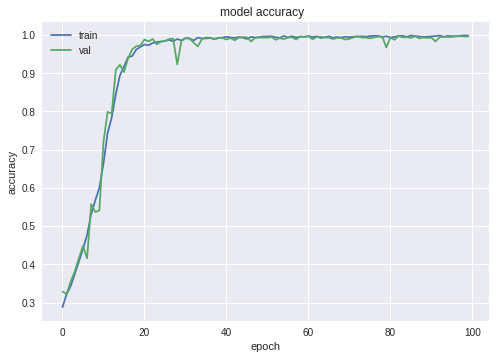

In [0]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'] )
plt.plot(history.history['val_categorical_accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

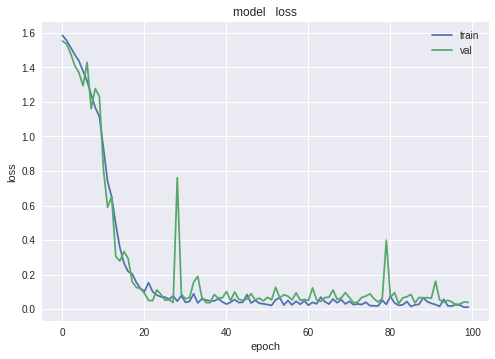

In [0]:
# summarize history for loss
plt.plot(history.history['loss'] )

plt.plot(history.history['val_loss'])
plt.title('model   loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()